In [1]:
import nltk
from nltk.tag import hmm, tnt, UnigramTagger, BigramTagger, DefaultTagger, brill
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
from nltk.tag import AffixTagger

nltk.download('cess_esp')
nltk.download('punkt')

corpus_sentences=nltk.corpus.cess_esp.tagged_sents()

reduced_corpus = [[ tuple([j[0], j[1][:3]])  for j in i if j[1][:2] not in ['*0', 'sn']] for i in corpus_sentences]
reduced_corpus = [[ tuple([j[0], j[1][:3]]) if j[1][0] in 'vF' else tuple([j[0], j[1][:2]]) for j in i ] for i in corpus_sentences]

[nltk_data] Downloading package cess_esp to
[nltk_data]     /home/labadier/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.
[nltk_data] Downloading package punkt to /home/labadier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Task 1

Number of tags in reduced corpus: 67
Number of tags: 289


/tmp/ipykernel_361122/2322092823.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus = list(np.array(corpus)[np.random.permutation(len(corpus))])
100%|██████████| 10/10 [04:03<00:00, 24.36s/it]


(-1.0, 10.0, 0.6, 1.0)

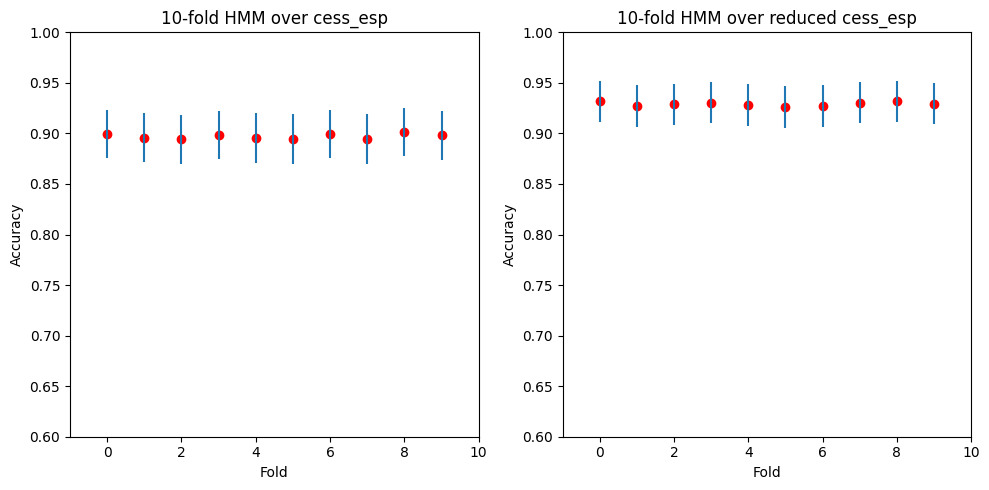

In [84]:
def trainHmm(corpus, name):


  corpus = list(np.array(corpus)[np.random.permutation(len(corpus))])
  val_len = int(len(corpus)/10)

  results = []

  # 10-folding
  for fold in tqdm(range(10)):

    val_set = corpus[fold*val_len:(fold+1)*val_len]
    train_set = corpus[:fold*val_len] + corpus[(fold+1)*val_len:]
    
    model=hmm.HiddenMarkovModelTagger.train(train_set)
    results += [model.accuracy(val_set)]
    with open(f'f1_measure_split:{fold}_data:{name}.txt', 'w') as file:
      file.write(model.evaluate_per_tag(val_set))

  conf  = [1.96 * np.sqrt( (i * (1 - i)) / val_len) for i in results]
  return model, results, conf  
  

n_tags = len(set([j[1] for sentence in corpus_sentences for j in sentence]))
nr_tags = len(set([j[1] for sentence in reduced_corpus for j in sentence]))

print(f'Number of tags in reduced corpus: {nr_tags}')
print(f'Number of tags: {n_tags}')

tagger_hmm, results_hmm, ci = trainHmm(corpus_sentences, 'full')
tagger_reduced_hmm, results_reduced_hmm, reduced_ci = trainHmm(reduced_corpus, 'reduced')

fig, axs = plt.subplots(1, 2)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True


axs[0].set_title('10-fold HMM over cess_esp')
axs[0].plot(np.arange(10), results_hmm,'ro')
axs[0].errorbar(np.arange(10), results_hmm, yerr = ci, linestyle='None')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Fold')
axs[0].axis([-1, 10, 0.6, 1])

axs[1].set_title('10-fold HMM over reduced cess_esp')
axs[1].plot(np.arange(10), results_reduced_hmm, 'ro')
axs[1].errorbar(np.arange(10), results_reduced_hmm, yerr = reduced_ci, linestyle='None')

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Fold')
axs[1].axis([-1, 10, 0.6, 1])

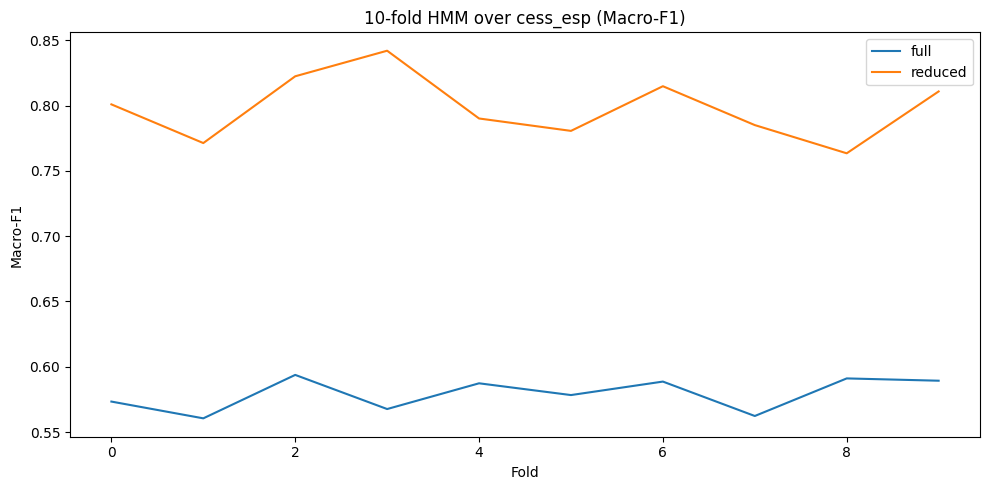

In [87]:
# Compute Macro-F1
stats = {'full': [], 'reduced': []}

d = 0
for name in stats:
  for fold in range(10):

    header = 2
    with open(f'f1_measure_split:{fold}_data:{name}.txt', 'r') as file:
      
      stats[name] += [[]]
      for lines in file:
        if header:
          header -= 1
          continue
        stats[name][-1] += [float(lines.split(' | ')[-1])]
      stats[name][-1] = np.mean(stats[name][-1])

plt.title('10-fold HMM over cess_esp (Macro-F1)')
plt.plot(np.arange(10), stats['full'])
plt.plot(np.arange(10), stats['reduced'])
plt.ylabel('Macro-F1')
plt.xlabel('Fold')
plt.legend(['full', 'reduced'], loc='upper right')


plt.savefig('macro-f1-hmm.png')
  

In [86]:
stats

{'full': [0.5733470319634703,
  0.5605057777777778,
  0.5937729357798165,
  0.5676279999999999,
  0.5873376744186046,
  0.5783287037037037,
  0.5886546296296297,
  0.5623034934497816,
  0.5910799086757992,
  0.5893222727272727],
 'reduced': [0.8009283333333332,
  0.7712983606557375,
  0.8224293103448277,
  0.8420140350877192,
  0.7901186440677965,
  0.7806274193548387,
  0.8148254237288136,
  0.7850616666666669,
  0.7634596774193549,
  0.8108275862068967]}

In [32]:
for i , j, k, l in zip(results_hmm, ci,results_reduced_hmm, reduced_ci ):
  print(f'{i:.3f}\pm{j:.2f}&{k:.3f}\pm{l:.2f}\\\\')
  


0.898\pm0.02&0.926\pm0.02\\
0.894\pm0.02&0.931\pm0.02\\
0.897\pm0.02&0.930\pm0.02\\
0.896\pm0.02&0.930\pm0.02\\
0.890\pm0.02&0.928\pm0.02\\
0.900\pm0.02&0.928\pm0.02\\
0.897\pm0.02&0.927\pm0.02\\
0.898\pm0.02&0.931\pm0.02\\
0.898\pm0.02&0.923\pm0.02\\
0.897\pm0.02&0.933\pm0.02\\


In [51]:
classes = {}
model = tagger_hmm
for sentence in corpus_sentences:
  for i in tagger_hmm.tag(sentence):

    if i[1] not in classes:
      classes[i[1]] = [0, 0, 0]

    if i[1] == i[0][1]:
      classes[i[1]][0] += 1
      continue

    classes[i[1]][1] += 1

    if i[0][1] not in model._states:
      continue

    if i[0][1] not in classes and i[0][1] in model._states:
     classes[i[0][1]] = [0, 0, 0]

    classes[i[0][1]][2] += 1

Task 2

/tmp/ipykernel_102175/2757822338.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus = list(np.array(reduced_corpus)[np.random.permutation(len(reduced_corpus))])
100%|██████████| 9/9 [01:18<00:00,  8.73s/it]


(0.0, 10.0, 0.6, 1.0)

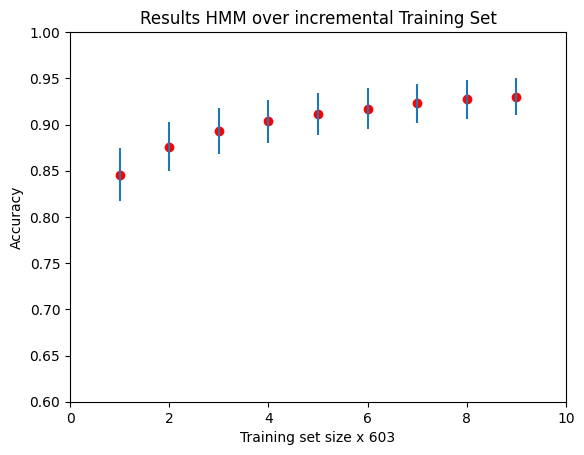

In [3]:
corpus = list(np.array(reduced_corpus)[np.random.permutation(len(reduced_corpus))])
val_len = int(len(corpus)/10)

results_hmm = []
val_set = corpus[:val_len]
train_set = []

for fold in tqdm(range(1, 10)):

  if fold < 9:
    train_set += corpus[fold*val_len:(fold+1)*val_len]
  else: train_set += corpus[fold*val_len:]

  
  tagger_hmm=hmm.HiddenMarkovModelTagger.train(train_set)
  results_hmm += [tagger_hmm.accuracy(val_set)]

ci = [1.96 * np.sqrt( (i * (1 - i)) / val_len) for i in results_hmm]

plt.title('Results HMM over incremental Training Set')
plt.plot(np.arange(1, 10), results_hmm,'ro')
plt.errorbar(np.arange(1, 10), results_hmm, yerr = ci, linestyle='None')
plt.ylabel('Accuracy')
plt.xlabel('Training set size x 603')
plt.axis([0, 10, 0.6, 1])

Task 3

Selección de Suffix Lenght

/tmp/ipykernel_102175/728939955.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus = list(np.array(reduced_corpus)[np.random.permutation(len(reduced_corpus))])
100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


<ErrorbarContainer object of 3 artists>

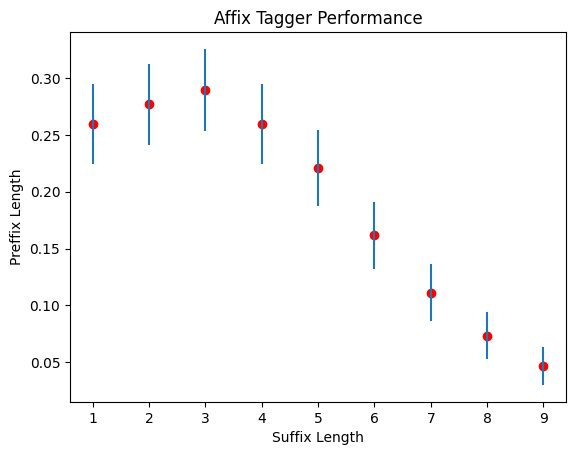

In [6]:
# 10-folding
corpus = list(np.array(reduced_corpus)[np.random.permutation(len(reduced_corpus))])
val_len = int(len(corpus)/10)

results_at = []
for length in range(1, 10):
  instance = []
  for fold in tqdm(range(10)):

    val_set = corpus[fold*val_len:(fold+1)*val_len]
    train_set = corpus[:fold*val_len] + corpus[(fold+1)*val_len:]
    
    affix_tagger = AffixTagger(train_set, affix_length=-length )
    instance += [affix_tagger.accuracy(val_set)]

  results_at += [np.mean(instance)]

ci_at = [1.96 * np.sqrt( (i * (1 - i)) / val_len) for i in results_at]
plt.title('Affix Tagger Performance')
plt.xlabel('Suffix Length')
plt.ylabel('Preffix Length')
plt.plot(np.arange(1, 10), results_at, 'ro')
plt.errorbar(np.arange(1, 10), results_at, yerr = ci_at, linestyle='None')

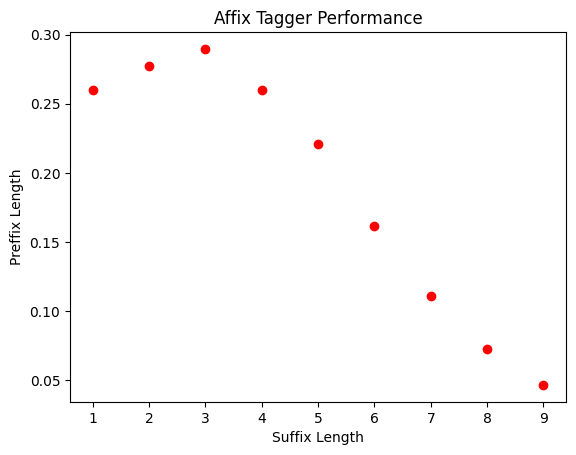

In [8]:
plt.title('Affix Tagger Performance')
plt.xlabel('Suffix Length')
plt.ylabel('Preffix Length')
plt.plot(np.arange(1, 10), results_at, 'ro')
# plt.errorbar(np.arange(1, 10), results_at, yerr = ci_at, linestyle='None')
plt.savefig('working notes/images/affix.png')

/tmp/ipykernel_2678/3540150578.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus = list(np.array(corpus)[np.random.permutation(len(corpus))])
100%|██████████| 10/10 [15:45<00:00, 94.55s/it]


(-1.0, 10.0, 0.6, 1.0)

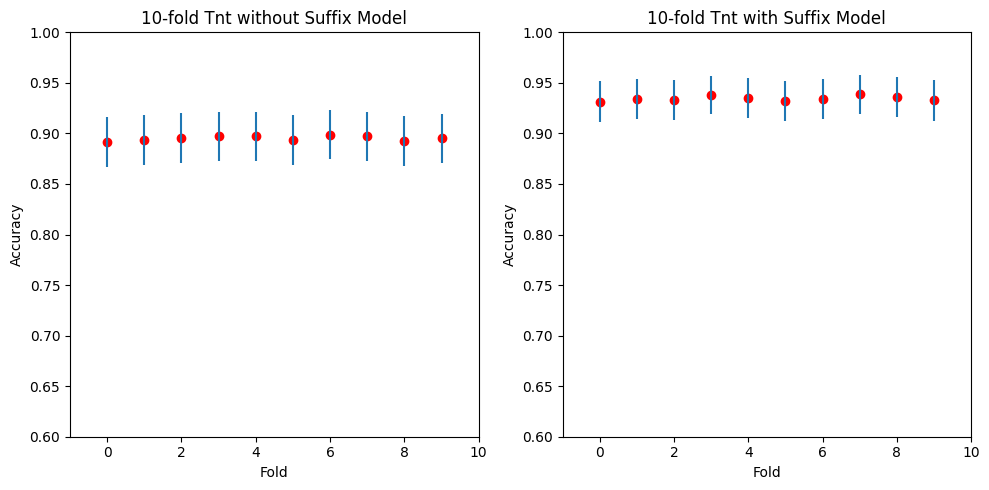

In [6]:
def trainTnt(corpus, unk = False):

  corpus = list(np.array(corpus)[np.random.permutation(len(corpus))])
  val_len = int(len(corpus)/10)

  results_tnt = []
  results_tnt_suff = []

  # 10-folding
  for fold in tqdm(range(10)):

    val_set = corpus[fold*val_len:(fold+1)*val_len]
    train_set = corpus[:fold*val_len] + corpus[(fold+1)*val_len:]

    if unk == False:
      tagger_tnt = tnt.TnT()
    else:
      affix_tagger = AffixTagger(train_set, affix_length=-3)
      tagger_tnt = tnt.TnT(unk=affix_tagger, Trained=True)

    tagger_tnt.train(train_set)
    
    results_tnt += [tagger_tnt.accuracy(val_set)]

  ci = [1.96 * np.sqrt( (i * (1 - i)) / val_len) for i in results_tnt]
  return tagger_tnt, results_tnt, ci

tagger_tnt_suff, results_tnt_suff, ci_suff = trainTnt(corpus_sentences, unk = True)
tagger_tnt, results_tnt, ci = trainTnt(corpus_sentences, unk = False)

fig, axs = plt.subplots(1, 2)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True


axs[0].set_title('10-fold Tnt without Suffix Model')
axs[0].plot(np.arange(10), results_tnt,'ro')
axs[0].errorbar(np.arange(10), results_tnt, yerr = ci, linestyle='None')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Fold')
axs[0].axis([-1, 10, 0.6, 1])

axs[1].set_title('10-fold Tnt with Suffix Model')
axs[1].plot(np.arange(10), results_tnt_suff, 'ro')
axs[1].errorbar(np.arange(10), results_tnt_suff, yerr = ci_suff, linestyle='None')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Fold')
axs[1].axis([-1, 10, 0.6, 1])

Task 4

brill-unigram
brill-bigram
brill-hmm
hmm
tnt
perceptron

In [10]:
corpus = list(np.array(reduced_corpus)[np.random.permutation(len(corpus))])
val_len = int(len(corpus)/10)
val_set = corpus[:val_len]
train_set = corpus[val_len:]
    

tagger_unigram = UnigramTagger(train_set, backoff=DefaultTagger('NN'))
tagger_bigram = BigramTagger(train_set, backoff=tagger_unigram)
tagger_hmm = hmm.HiddenMarkovModelTagger.train(train_set)
tagger_tnt = tnt.TnT()
tagger_tnt.train(train_set)

results = {'unigram':tagger_unigram.accuracy(val_set), 'tagger_bigram':tagger_bigram.accuracy(val_set), 'HMM':tagger_hmm.accuracy(val_set), 
            'Tnt':tagger_tnt.accuracy(val_set)}

## Brill
def get_brill_tagger(base_tagger, data, rules=256):

  brill.Template._cleartemplates()
  templates = brill.fntbl37()
  trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=base_tagger,
                                    templates=templates, trace=3,
                                    deterministic=True)

  tagger = trainer.train(data, max_rules=rules)
  return tagger

brill_models = {}
for rules in [256, 512, 1024]:
  brill_models[f'brill-unigram-{rules}'] = get_brill_tagger(tagger_unigram, train_set, rules=rules)
  results[f'brill-unigram-{rules}'] = brill_models[f'brill-unigram-{rules}'].accuracy(val_set)
  brill_models[f'brill-bigram-{rules}'] = get_brill_tagger(tagger_bigram, train_set, rules=rules)
  results[f'brill-bigram-{rules}'] = brill_models[f'brill-bigram-{rules}'].accuracy(val_set)
  brill_models[f'brill-hmm-{rules}'] = get_brill_tagger(tagger_hmm, train_set, rules=rules)
  results[f'brill-hmm-{rules}'] = brill_models[f'brill-hmm-{rules}'].accuracy(val_set)

/tmp/ipykernel_2678/637510250.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus = list(np.array(reduced_corpus)[np.random.permutation(len(corpus))])


TBL train (fast) (seqs: 5427; tokens: 173401; tpls: 37; min score: 2; min acc: None)
Finding initial useful rules...
    Found 104273 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
11021232 130   0  | pr->cs if Pos:vmi@[-3,-2,-1]
 238 251  13   0  | da->pp if Pos:vmi@[1]
 204 301  97   0  | pr->cs if Word:que@[0] & Pos:sp@[-1]
 173 329 156  11  | nc->aq if Pos:nc@[-1]
 100 124  24   0  | pr->cs if Pos:vai@[-3,-2,-1]
  88 107  19  10  | di->pi if Pos:sp@[1]
  88 134  46   1  | pr->cs if Pos:rg@[-2,-1]
  77  84   7   0  | aq->vmp if Pos:vai@[-1]
  71  72   1   0  | pr->cs if Word:que@[0] & Pos:vmn@[-1]
  62  65   3   0  | vmp->aq if Pos

In [11]:
print(results)

{'unigram': 0.8843142338605133, 'tagger_bigram': 0.8989369976665802, 'HMM': 0.9305159450350013, 'Tnt': 0.9050038890329272, 'brill-unigram-256': 0.9043816437645839, 'brill-bigram-256': 0.9040186673580503, 'brill-hmm-256': 0.9345605392792325, 'brill-unigram-512': 0.9041742286751361, 'brill-bigram-512': 0.9040186673580503, 'brill-hmm-512': 0.9349235156857661, 'brill-unigram-1024': 0.9041742286751361, 'brill-bigram-1024': 0.9040186673580503, 'brill-hmm-1024': 0.9349235156857661}
